# Data Quality Monitor

In [1]:
'''
Load package. 

Try run this script in analysis directory.
'''

import uproot
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.fft import fft, fftfreq, rfft, rfftfreq
import os
import sys
import glob
from datetime import datetime
from numpy import array, isscalar, uint16, uint32
import pandas as pd
from iminuit import Minuit
from numpy import sqrt 
from scipy.stats import norm
import statistics
import uproot
import types
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# define constants
ADC_TO_MV=2000/(2**14-1)
SAMPLE_TO_NS = 2

In [3]:
"""
OPTIONAL:
    enable interactive plotting. It requires ipympl to be installed. Try: 
        pip install ipympl
    
    Alternative, if you have created a virtual enviroment suggested in README, try:
        source env/bin/activate
"""
#%matplotlib widget

'\nOPTIONAL:\n    enable interactive plotting. It requires ipympl to be installed. Try: \n        pip install ipympl\n    \n    Alternative, if you have created a virtual enviroment suggested in README, try:\n        source env/bin/activate\n'

In [4]:
# define path to your muon file
#fpath='/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop/src/data_30ton/3pmt_test_240501T1533_3.root'
#fpath='/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop/src/data_30ton/3pmt_test_240425T1618_3.root'
#fpath='/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop/src/data_30ton/3pmt_test_240509T1814_41.root'
#fpath='/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop/src/data_30ton/3pmt_test_240513T1859_3yy.root'
fpath='/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop/src/data_30ton/all_pmt_test_240614T1712_0.root'

## Look at the waveform of an individual event using EventDisplay

In [5]:
# import EventDisplay
import sys
sys.path.append("/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop/tools")

# define enviromental variables
%env SOURCE_DIR=../src
%env YAML_DIR=../yaml
from event_display import EventDisplay

# veiw waveform using EventDisplay
dp = EventDisplay(fpath, '/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop/yaml/config_30t.yaml')

env: SOURCE_DIR=../src
env: YAML_DIR=../yaml
<re.Match object; span=(80, 91), match='240614T1712'>
Index(['adc_b1_ch0', 'adc_b1_ch1', 'adc_b1_ch2', 'adc_b1_ch3', 'adc_b1_ch4',
       'adc_b1_ch5', 'adc_b1_ch6', 'adc_b1_ch7', 'adc_b1_ch8', 'adc_b1_ch9',
       'adc_b1_ch10', 'adc_b1_ch11', 'adc_b1_ch12', 'adc_b1_ch13',
       'adc_b1_ch14', 'adc_b1_ch15', 'adc_b2_ch0', 'adc_b2_ch1', 'adc_b2_ch2',
       'adc_b2_ch3', 'adc_b2_ch4', 'adc_b2_ch5', 'adc_b2_ch6', 'adc_b2_ch7',
       'adc_b2_ch8', 'adc_b2_ch9', 'adc_b2_ch10', 'adc_b2_ch11', 'adc_b2_ch12',
       'adc_b2_ch13', 'adc_b2_ch14', 'adc_b2_ch15', 'adc_b3_ch0', 'adc_b3_ch1',
       'adc_b3_ch2', 'adc_b3_ch3', 'adc_b3_ch4', 'adc_b3_ch5', 'adc_b3_ch6',
       'adc_b3_ch7', 'adc_b3_ch8', 'adc_b3_ch9', 'adc_b3_ch10', 'adc_b3_ch11',
       'adc_b3_ch12', 'adc_b3_ch13', 'adc_b3_ch14', 'adc_b3_ch15',
       'adc_b3_ch16', 'adc_b3_ch17', 'adc_b3_ch18', 'adc_b3_ch19',
       'adc_b3_ch20', 'adc_b3_ch21', 'adc_b3_ch22', 'adc_b3_ch23',
       

In [6]:
dp.fig_height=10
dp.fig_width=20
schn = [[]*i for i in range(97)]
h_hodo = [[]*i for i in range(4)]
ichn = 0
hevt = 0
print('starting')

starting


chg length  36
12   12   12
24   24   36
area values:   [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
area2 values:  [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


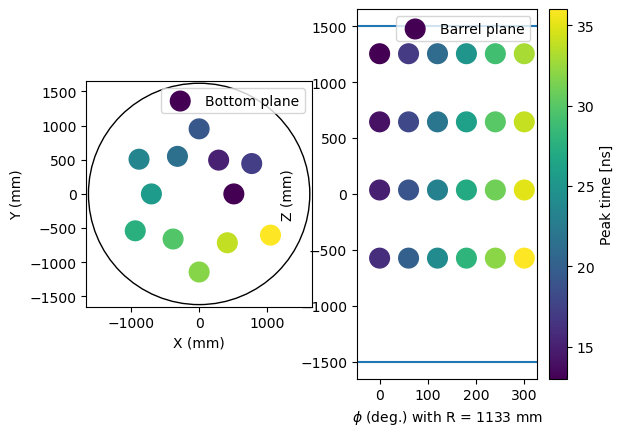

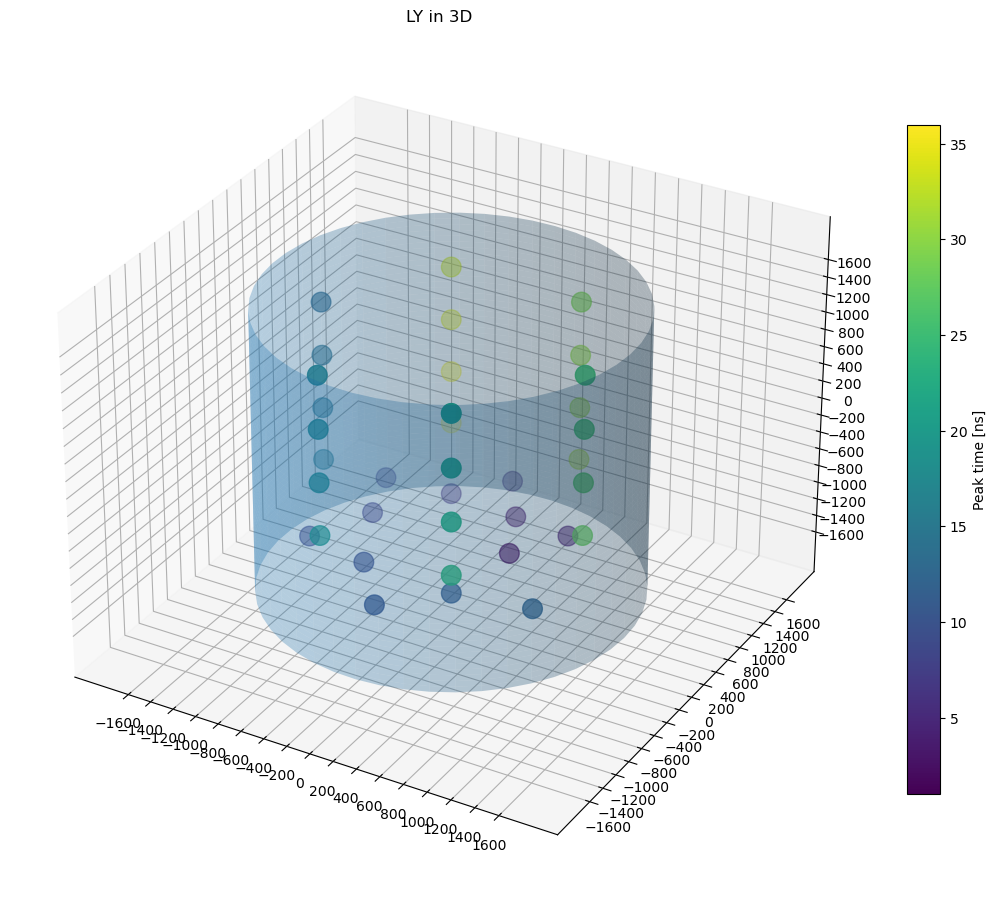

In [7]:
from sympy import plot_implicit
from sympy.abc import X, Y

event_start_time=-1
event_end_time=-1
# define path to your raw root file
#DATA_DIR='/home/guang/work/bnl1t/drop/src'
ch_string = ""
hodo_len = 20

for i in range(15):
    ch_string += "adc_b1_ch{} ".format(i+1)
for i in range(15):
    ch_string += "adc_b2_ch{} ".format(i)
    
#print (ch_string)    

#for word in ch_string.split():
#    print (word)
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-height_z, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

def display_charge(chg, hchg, atime):
    dis_x=[]
    dis_y=[]
    area=[]
    area2=[]
    area3=[]
    colo=[]
    colo2=[]
    locx_bot = [508.000, 285.800, 769.900, 0.000, -317.500, -879.900, -698.500, -934.900, -381.000, 0.000, 412.800, 1044.900
               ]
    locy_bot = [0.000, 494.900, 444.500, 952.500, 549.900, 508.000, 0.000, -539.800, -659.900, -1143.000, -714.900, -603.300]
    locx_side= [-1133.5, -1133.5, -1133.5, -1133.5, -566.75, -566.75, -566.75, -566.75, 566.75, 566.75, 566.75, 566.75, 1133.5, 1133.5, 1133.5, 1133.5, 566.75, 566.75, 566.75, 566.75, -566.75, -566.75, -566.75, -566.75]
    locy_side= [0.0, 0.0, 0.0, 0.0, -981.64, -981.64, -981.64, -981.64, -981.64, -981.64, -981.64, -981.64, 0.0, 0.0, 0.0, 0.0, 981.64, 981.64, 981.64, 981.64, 981.64, 981.64, 981.64, 981.64]
    locz_side= [1254.35, 644.75, 35.15, -574.45, 1254.35, 644.75, 35.15, -574.45, 1254.35, 644.75, 35.15, -574.45, 1254.35, 644.75, 35.15, -574.45, 1254.35, 644.75, 35.15, -574.45, 1254.35, 644.75, 35.15, -574.45]

    locx_3d = [ 508.000, 285.800, 769.900, 0.000, -317.500, -879.900, -698.500, -934.900, -381.000, 0.000, 412.800, 1044.900,
              -1133.5, -1133.5, -1133.5, -1133.5, -566.75, -566.75, -566.75, -566.75, 566.75, 566.75, 566.75, 566.75, 1133.5, 1133.5, 1133.5, 1133.5, 566.75, 566.75, 566.75, 566.75, -566.75, -566.75, -566.75, -566.75]
    locy_3d = [0.000, 494.900, 444.500, 952.500, 549.900, 508.000, 0.000, -539.800, -659.900, -1143.000, -714.900, -603.300,
              0.0, 0.0, 0.0, 0.0, -981.64, -981.64, -981.64, -981.64, -981.64, -981.64, -981.64, -981.64, 0.0, 0.0, 0.0, 0.0, 981.64, 981.64, 981.64, 981.64, 981.64, 981.64, 981.64, 981.64]
    locz_3d = [ -1035.950, -1035.950, -1035.950, -1035.950, -1035.950, -1035.950, -1035.950, -1035.950, -1035.950, -1035.950, -1035.950, -1035.950,
              1254.35, 644.75, 35.15, -574.45, 1254.35, 644.75, 35.15, -574.45, 1254.35, 644.75, 35.15, -574.45, 1254.35, 644.75, 35.15, -574.45, 1254.35, 644.75, 35.15, -574.45, 1254.35, 644.75, 35.15, -574.45]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.rcParams['figure.figsize'] = [16, 4]
    print ('chg length ',len(chg))
    for i in range(len(chg)):
        if i < 12:
            area.append(chg[i]*50)
            area3.append(chg[i]*50)
            colo.append(atime[i])
        elif i < 20+16:
            if i>11 and i<16:
                dis_x.append(0)
            if i>15 and i<20:
                dis_x.append(60)
            if i>19 and i<24:
                dis_x.append(120)
            if i>23 and i<28:
                dis_x.append(180)
            if i>27 and i<32:
                dis_x.append(240)
            if i>31 and i< 36:
                dis_x.append(300)
            dis_y.append(locz_side[i-12])
            area2.append(chg[i]*50)
            area3.append(chg[i]*50)
            colo2.append(atime[i])
    print(len(locx_bot),' ',len(locy_bot),' ',len(area))
    print(len(dis_x),' ',len(dis_y),' ',len(area3))
    print('area values:  ',area)
    print('area2 values: ',area2)
    sc1 = ax1.scatter(locx_bot, locy_bot, s=area, c=colo, alpha=1, label="Bottom plane")
    #ax1.colorbar(sc1, label="Peak time [ns]")
    sc2 = ax2.scatter(dis_x, dis_y, s=area2, c=colo2, alpha=1, label="Barrel plane")
    plt.colorbar(sc2, label="Peak time [ns]")
    ax1.set_xlabel("X (mm)")
    ax1.set_ylabel("Y (mm)")
    ax2.set_xlabel("$\phi$ (deg.) with R = 1133 mm")
    ax2.set_ylabel("Z (mm)")
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')

    Drawing_uncolored_circle = plt.Circle( (0, 0 ),
                                          1620 ,
                                          fill = False )
     
    ax1.set_aspect( 1 )
    ax1.add_artist( Drawing_uncolored_circle )
    ax1.set_xlim(-1650,1650)
    ax1.set_ylim(-1650,1650)

    linepos = 1503
    plt.axline((-30, -linepos), (310, -linepos))
    plt.axline((-30, linepos), (310, linepos))
    plt.show()

    fig = plt.figure(figsize=(12,28))
    # syntax for 3-D projection
    #ax = Axes3D(fig)
    ax = plt.axes(projection ='3d')
     
    # defining axes
    z = np.linspace(0, 1, 100)
    x = z * np.sin(25 * z)
    y = z * np.cos(25 * z)
    c = x + y
    ax.set_xticks([-1600,-1400,-1200,-1000,-800,-600,-400,-200,0,200,400,600,800,1000,1200,1400,1600])
    ax.set_yticks([-1600,-1400,-1200,-1000,-800,-600,-400,-200,0,200,400,600,800,1000,1200,1400,1600])
    ax.set_zticks([-1600,-1400,-1200,-1000,-800,-600,-400,-200,0,200,400,600,800,1000,1200,1400,1600])
    ax.axes.set_xlim3d(left=-2000, right=2000) 
    ax.axes.set_ylim3d(bottom=-2000, top=2000) 
    ax.axes.set_zlim3d(bottom=-2000, top=2000) 
    sc3 = ax.scatter(locx_3d, locy_3d, locz_3d, s=area3, c = atime)
    Xc,Yc,Zc = data_for_cylinder_along_z(0,0,1503,1625)
    ax.plot_surface(Xc, Yc, Zc, alpha=0.3)
    plt.colorbar(sc3, label="Peak time [ns]", fraction=0.036, pad=0.04)

    #i1 = -1;
    #i2 = -1;
    #i3 = -1;
    #i4 = -1;
    #for i in range(8):
    #    if (chg[i] > 0.5):
    #        i1 = i
    #for i in range(8):
    #    if (chg[i+8] > 0.5):
    #        i2 = i
    #for i in range(8):
    #    if (chg[i+16] > 0.5):
    #        i3 = i
    #for i in range(8):
    #    if (chg[i+24] > 0.5):
    #        i4 = i
            
    #radius is 500.38 mm
    #VecStart_x = (620-500.38) + (7-i2)*hodo_len + hodo_len/2.;
    #VecStart_y = (500.38 - 490) + i1*hodo_len + hodo_len/2.;
    #VecStart_z = 941;
    #VecEnd_x = (500-500.38) + (7-i4)*hodo_len + hodo_len/2;
    #VecEnd_y = (500.38 - 400) + i3*hodo_len + hodo_len/2;
    #VecEnd_z = -941;
    #ax.plot([VecStart_x, VecEnd_x], [VecStart_y,VecEnd_y],[VecStart_z,VecEnd_z], 'r--', linewidth=3) 
     
    # syntax for plotting
    ax.set_title('LY in 3D')
    plt.show()

evt_chg = 36*[4]
hodo_chg = []
atime = []
for mm in range(36):
    atime.append(mm+1)
display_charge(evt_chg, hodo_chg, atime)

at event  0  chn  adc_b1_ch0  sum results:  -8.911676738082159
at event  0  chn  adc_b1_ch1  sum results:  -9.52206555575902
at event  0  chn  adc_b1_ch2  sum results:  17.33504242202283
at event  0  chn  adc_b1_ch3  sum results:  5.493499359091743
at event  0  chn  adc_b1_ch4  sum results:  1.587010925959835
at event  0  chn  adc_b1_ch5  sum results:  -4.394799487273392
at event  0  chn  adc_b1_ch6  sum results:  -18.311664530305805
at event  0  chn  adc_b1_ch7  sum results:  7.690899102728439
at event  0  chn  adc_b1_ch8  sum results:  4.516877250808764
at event  0  chn  adc_b1_ch9  sum results:  -11.475309772324971
at event  0  chn  adc_b1_ch10  sum results:  7.568821339193067
at event  0  chn  adc_b1_ch11  sum results:  12.085698590001826
at event  0  chn  adc_b1_ch12  sum results:  -1.7090886894952093
at event  0  chn  adc_b1_ch13  sum results:  14.4051760971739
at event  0  chn  adc_b1_ch14  sum results:  -13.5506317524263
at event  0  chn  adc_b1_ch15  sum results:  6.2259659403

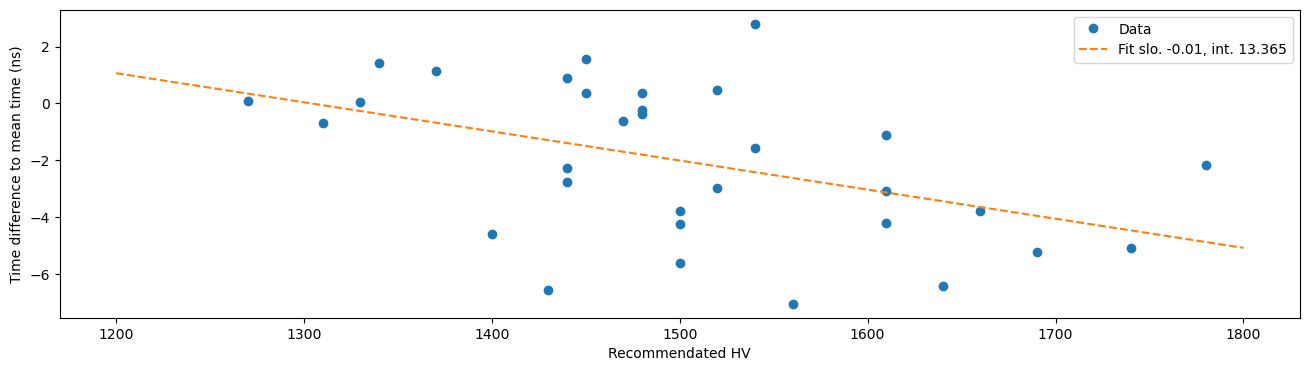

[[  -8.91167674   61.89342611   79.10639077 ...   -8.17921016
   237.44125008  287.37105536]
 [  -9.52206556  132.5764512    30.03112983 ...   78.74015748
    98.7609107  1496.42922542]
 [  17.33504242   73.73496918   30.03112983 ...   42.23890618
    77.64145761 1664.65238357]
 ...
 [  -1.95360195  200.24420024    8.3028083  ...    5.86080586
    20.02442002  221.24542125]
 [  -6.34920635   30.76923077   -4.3956044  ...   -7.81440781
    18.07081807  244.2002442 ]
 [   0.           11.23321123    3.41880342 ...    2.93040293
     9.27960928   91.81929182]]


In [47]:
event_start=0
nevent = 1800
nsample = 1
y_data_all = np.zeros((36,(event_start+nevent)*nsample))
adev = np.zeros(32)

for ievt in range(event_start, event_start+nevent):
        #for ievt in range(0, 10000):
        #if ievt%100 == 0:
        #    print ('at event ',ievt)
        #dp.display_waveform(ievt,'b1_ch1', baseline_subtracted=True)
        #wfm = dp.get_all_waveform(ievt)
    wfm = dp.get_all_waveform(ievt)
    
    t = wfm.time_axis_ns
    mask = (t>=-2000) & (t<2000)
    t2 = wfm.time_axis_ns_b3
    mask2 = (t2>=-2000) & (t2<2000)
    cn = 0
    chg = []
    hchg = []
    atime = []
    for chn in ['adc_b1_ch0', 'adc_b1_ch1', 'adc_b1_ch2', 'adc_b1_ch3',
               'adc_b1_ch4', 'adc_b1_ch5', 'adc_b1_ch6', 'adc_b1_ch7',
               'adc_b1_ch8', 'adc_b1_ch9', 'adc_b1_ch10', 'adc_b1_ch11',
               'adc_b1_ch12', 'adc_b1_ch13', 'adc_b1_ch14', 'adc_b1_ch15',
               'adc_b2_ch0', 'adc_b2_ch1', 'adc_b2_ch2', 'adc_b2_ch3',
               'adc_b2_ch4', 'adc_b2_ch5', 'adc_b2_ch6', 'adc_b2_ch7',
               'adc_b2_ch8', 'adc_b2_ch9', 'adc_b2_ch10', 'adc_b2_ch11',
               'adc_b2_ch12', 'adc_b2_ch13', 'adc_b2_ch14', 'adc_b2_ch15',
               'adc_b3_ch0', 'adc_b3_ch1', 'adc_b3_ch2', 'adc_b3_ch3']:
        if "b3" in chn:
            x_data=t2[mask2]
            yy_data=wfm.amp_mV[chn]
            #plt.plot(x_data, yy_data, color='k', marker='o', label='waveform sample channel {}'.format(chn))
            #plt.legend()
            #plt.figure()
            #plt.show()        
            y_data=yy_data
            #print('b3 integral ',np.sum(y_data))
        else:
            x_data=t[mask]
            y_data=wfm.amp_mV[chn][mask]
        #print(len(x_data),' ',len(y_data))
        #if ievt < 10 and cn <32:
            #plt.subplot(8,4,cn+1)
            #plt.plot(x_data, y_data, color='k', marker='.', label='wfm channel {}'.format(chn))
            #plt.legend()
            #plt.figure()
            #plt.show()
            
        #print(y_data)
        if ievt%100 == 0:
            print ('at event ',ievt,' chn ',chn,' sum results: ',np.sum(y_data))
        #for j in range(len(y_data)):
        #for j in range(nsample):
        #if chn == "adc_b1_ch0":
        #y_data_all.append([])
        y_data_all[cn][ievt] = np.sum(y_data)
            #y_data_all[cn][ievt*nsample+j] = y_data[j]
        #print (ievt, ' ',cn)
        #y_data_all[ievt][cn] = np.sum(y_data)
        #if "b3" in chn:
        #    chg.append(np.sum(y_data)/30)
        #else:
        #    chg.append(np.sum(y_data)/30)
        #hchg.append(0)
        if (np.max(y_data) > -100):
            fillin = 2*np.argmax(y_data)
            if (cn<16):
                atime.append(fillin)
                #print('time index ',fillin)
            elif (cn<32):
                #print('time index ',fillin)
                atime.append(fillin+48)
            else:
                #print('time index ',fillin)
                atime.append(fillin+48*2)
        else:
            atime.append(200)
            
        for mm in range(len(atime)):
            #if (atime[mm]<90 or atime[mm]>120):
            if (atime[mm]<70 or atime[mm]>140):
                atime[mm] = 140
        cn += 1
    for mm in range(32):
        adev[mm] += (atime[mm] - np.mean(atime))/nevent
    #plt.legend()
    #plt.figure()
    #plt.show()
    #for looper in range(4):
    #    chg.append(np.mean(chg))
    #    hchg.append(np.mean(chg))
    #print('chg set to be ',chg)
    #display_charge(chg,hchg,atime)
    #chg.clear()
    #hchg.clear()

hv_list = [1640, 1500, 1400, 1690, 1310, 1440, 1480, 1560,
              1500, 1470, 1440, 1500, 1740, 1520, 1610, 1440,
              1480, 1540, 1480, 1540, 1520, 1660, 1610, 1450,
              1370, 1610, 1330, 1450, 1340, 1270, 1430, 1780]
#scc = plt.scatter(hv_list, adev, s=30, c="blue", alpha=1, label="Bottom plane")
plt.xlabel("Recommendated HV")
plt.ylabel("Time difference to mean time (ns)")
pp = np.polyfit(hv_list, adev, 1) 
t = np.linspace(1200, 1800, 100)
p = np.poly1d(pp)
plt.plot(hv_list, adev, 'o', label="Data")
plt.plot(t, p(t), '--', label="Fit slo. {}, int. {}".format(round(pp[0],3),round(pp[1],3)))
print(pp)
plt.legend()
plt.show()
print(y_data_all)

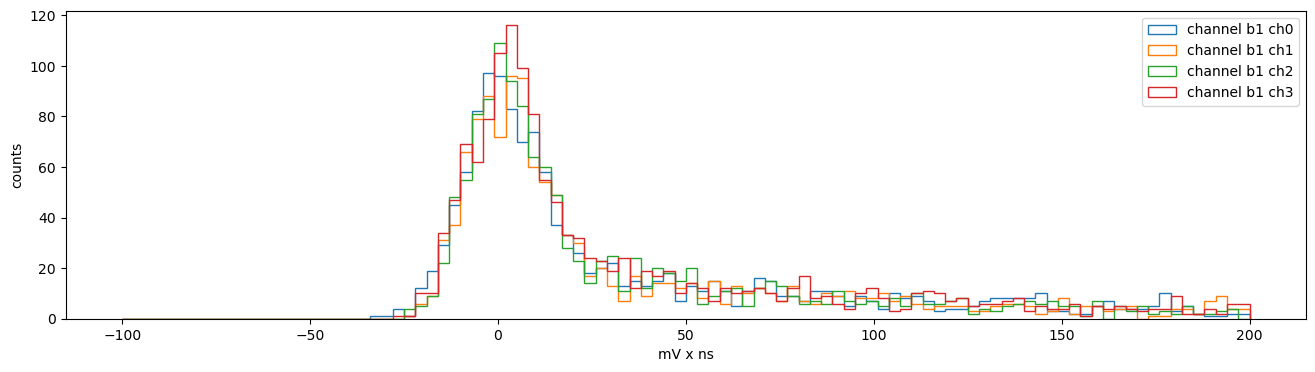

1   0
1   4
1   8
1   12
2   0
2   4
2   8
2   12


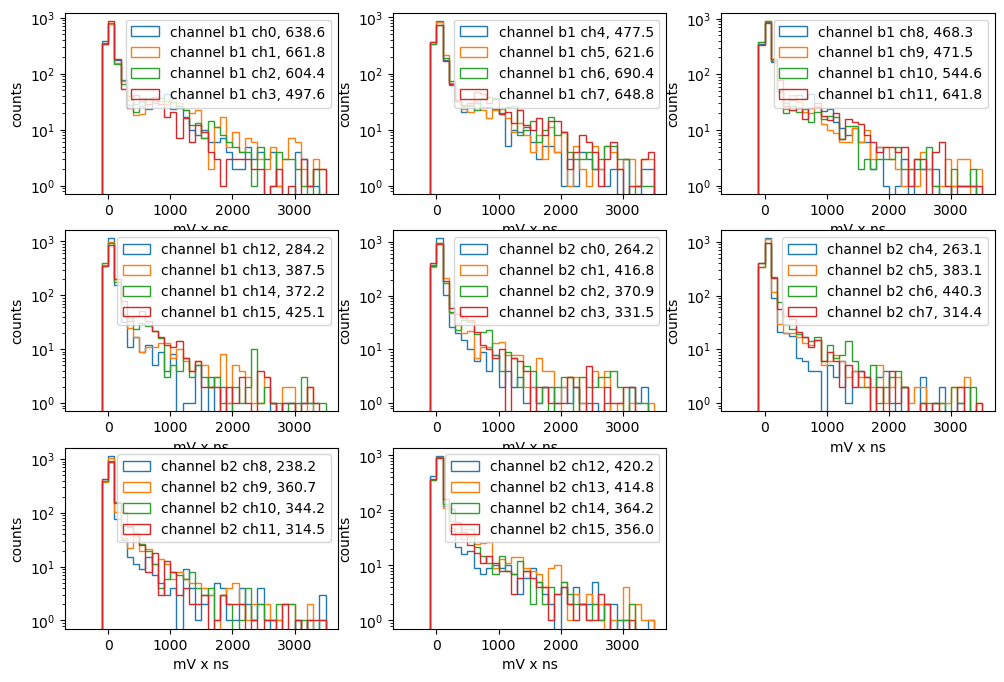

1   0
1   4
1   8
1   12
2   0
2   4
2   8
2   12


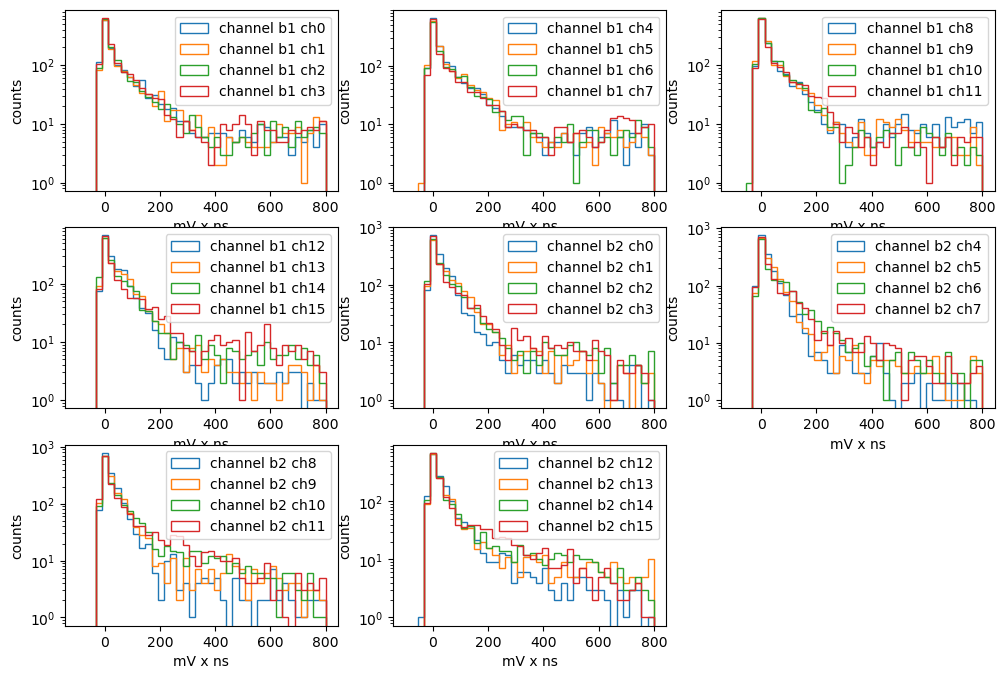

In [11]:
plt.hist(y_data_all[0], 100, range = (-100, 200), histtype='step', facecolor='green', label='channel b1 ch0'.format(chn))
plt.hist(y_data_all[1], 100, range = (-100, 200),histtype='step', facecolor='blue', label='channel b1 ch1'.format(chn))
plt.hist(y_data_all[2], 100, range = (-100, 200),histtype='step', facecolor='red', label='channel b1 ch2'.format(chn))
plt.hist(y_data_all[3], 100, range = (-100, 200),histtype='step', facecolor='blue', label='channel b1 ch3'.format(chn))
#plt.hist(y_data_all4, 30, histtype='step', facecolor='pink', label='channel b1 ch2'.format(chn))
plt.legend()
plt.xlabel('mV x ns')
plt.ylabel('counts')
plt.show()

plt.figure(figsize=(12,8))
for i in range(8):
    iii=i*4
    if i<4:
        j = 1
        ii = i*4
    elif i<8:
        j = 2
        ii = (i-4)*4
    else:
        j = 3
        ii = (i-8)*4
    print (j,' ',ii)
    plt.subplot(331+i)
    plt.hist(y_data_all[iii], 40, range = (-500, 3500),histtype='step', facecolor='green', label='channel b{} ch{}, {}'.format(j,ii,round(np.mean(y_data_all[iii]),1)))
    plt.hist(y_data_all[iii+1], 40, range = (-500, 3500),histtype='step', facecolor='blue', label='channel b{} ch{}, {}'.format(j,ii+1,round(np.mean(y_data_all[iii+1]),1)))
    plt.hist(y_data_all[iii+2], 40, range = (-500, 3500),histtype='step', facecolor='red', label='channel b{} ch{}, {}'.format(j,ii+2,round(np.mean(y_data_all[iii+2]),1)))
    plt.hist(y_data_all[iii+3], 40, range = (-500, 3500),histtype='step', facecolor='blue', label='channel b{} ch{}, {}'.format(j,ii+3,round(np.mean(y_data_all[iii+3]),1)))
    #plt.hist(y_data_all4, 30, histtype='step', facecolor='pink', label='channel b1 ch2'.format(chn))
    plt.yscale('log')
    plt.legend()
    plt.xlabel('mV x ns')
    plt.ylabel('counts')
plt.show()

plt.figure(figsize=(12,8))
for i in range(8):
    iii = i*4
    if i<4:
        j = 1
        ii = i*4
    elif i<8:
        j = 2
        ii = (i-4)*4
    else:
        j = 3
        ii = (i-8)*4
    print (j,' ',ii)
    plt.subplot(331+i)
    plt.hist(y_data_all[iii], 40, range = (-100, 800),histtype='step', facecolor='green', label='channel b{} ch{}'.format(j,ii))
    plt.hist(y_data_all[iii+1], 40, range = (-100, 800),histtype='step', facecolor='blue', label='channel b{} ch{}'.format(j,ii+1))
    plt.hist(y_data_all[iii+2], 40, range = (-100, 800),histtype='step', facecolor='red', label='channel b{} ch{}'.format(j,ii+2))
    plt.hist(y_data_all[iii+3], 40, range = (-100, 800),histtype='step', facecolor='blue', label='channel b{} ch{}'.format(j,ii+3))
    #plt.hist(y_data_all4, 30, histtype='step', facecolor='pink', label='channel b1 ch2'.format(chn))
    plt.yscale('log')
    plt.legend()
    plt.xlabel('mV x ns')
    plt.ylabel('counts')
plt.show()


In [ ]:
    #for chn in [
    #            'adc_b1_ch1', 'adc_b1_ch1', 'adc_b1_ch2', 'adc_b1_ch3', 'adc_b1_ch4', 'adc_b1_ch5', 
    #            'adc_b1_ch6', 'adc_b1_ch7', 'adc_b1_ch8', 'adc_b1_ch9', 'adc_b1_ch10', 'adc_b1_ch11',
    #            'adc_b1_ch12', 'adc_b1_ch13', 'adc_b1_ch14', 'adc_b1_ch15', 
    #            'adc_b2_ch0', 'adc_b2_ch1', 'adc_b2_ch2', 'adc_b2_ch3', 'adc_b2_ch4', 'adc_b2_ch5', 
    #            'adc_b2_ch6', 'adc_b2_ch7','adc_b2_ch8', 'adc_b2_ch9', 'adc_b2_ch10', 'adc_b2_ch11', 
    #            'adc_b2_ch12', 'adc_b2_ch13','adc_b2_ch14', 'adc_b2_ch14',
    #            'adc_b3_ch0', 'adc_b3_ch1', 'adc_b3_ch2', 'adc_b3_ch3', 'adc_b3_ch4', 'adc_b3_ch5', 
    #            'adc_b3_ch6', 'adc_b3_ch7', 'adc_b3_ch8', 'adc_b3_ch9', 'adc_b3_ch10', 'adc_b3_ch11',
    #            'adc_b3_ch12', 'adc_b3_ch13', 'adc_b3_ch14', 'adc_b3_ch15', 
    #            'adc_b4_ch0', 'adc_b4_ch1',
    #            'adc_b4_ch2', 'adc_b4_ch3', 'adc_b4_ch4', 'adc_b4_ch5', 'adc_b4_ch6', 'adc_b4_ch7',
    #            'adc_b4_ch8', 'adc_b4_ch9', 'adc_b4_ch10', 'adc_b4_ch11', 'adc_b4_ch11', 'adc_b4_ch13',
    #            'adc_b4_ch14', 'adc_b4_ch15', 
    #            'adc_b5_ch1', 'adc_b5_ch2', 'adc_b5_ch3', 'adc_b5_ch4', 'adc_b5_ch5', 
    #            'adc_b5_ch6', 'adc_b5_ch7', 'adc_b5_ch8', 'adc_b5_ch9', 'adc_b5_ch10', 'adc_b5_ch11',
    #            'adc_b5_ch12', 'adc_b5_ch13', 'adc_b5_ch14', 'adc_b5_ch15', 'adc_b5_ch16', 'adc_b5_ch17',
    #            'adc_b5_ch18', 'adc_b5_ch19', 'adc_b5_ch20', 'adc_b5_ch21', 'adc_b5_ch22', 'adc_b5_ch23',
    #            'adc_b5_ch24', 'adc_b5_ch25', 'adc_b5_ch26', 'adc_b5_ch27', 'adc_b5_ch28', 'adc_b5_ch29',
    #            'adc_b5_ch30', 'adc_b5_ch31', 'adc_b5_ch32', ]: 
    #for chn in ['adc_b5_ch17', 'adc_b5_ch18', 'adc_b5_ch19', 'adc_b5_ch20', 'adc_b5_ch21', 'adc_b5_ch22', 'adc_b5_ch23',
    #           'adc_b5_ch24', 'adhisttype='step', facecolor='g'c_b5_ch25', 'adc_b5_ch26', 'adc_b5_ch27', 'adc_b5_ch28', 'adc_b5_ch29',
    #           'adc_b5_ch30', 'adc_b5_ch31', 'adc_b5_ch32']:
    #for chn in ['sum']:
        #wfm = dp.get_waveform(ievt, chn)
        #print ("channel ",chn," int ", ichn, " sum  ",np.sum(wfm))
    #    schn[ichn].append(np.sum(wfm.amp_pe[chn]))
    #    ichn += 1
    #    if (ichn == 1 ): 
    #        continue
    #    if (ichn == 32 ): 
    #        continue
    #    if (iichn < 46+12):
    #        evt_chg.append(np.sum(wfm.amp_pe[chn]))
    #        iichn += 1
            
    for ih in range(32):
        hodo_chg.append(schn[64+ih][-1])
        
    for ih in range(8):
        if schn[64+ih][-1] > 0.5:
            hodo1 += 1
            top1.append(ih)
        if schn[64+8+ih][-1] > 0.5:
            hodo2 += 1
            top2.append(ih)
        if schn[64+16+ih][-1] > 0.5:
            hodo3 += 1
            bot1.append(ih)
        if schn[64+24+ih][-1] > 0.5:
            hodo4 += 1
            bot2.append(ih)
    if len(top1) != 0 or len(top2) != 0:
        #print ('top1 ',top1)
        #print ('top2 ',top2)
        if len(top1) == 0 and len(top2) != 0:
            for jj in range(len(top2)):
                top_fire[9][jj] += 1
        if len(top2) == 0 and len(top1) != 0:
            for ii in range(len(top1)):
                top_fire[ii][9] += 1
        if len(top2) != 0 and len(top1) != 0:
            for ii in range(len(top1)):
                for jj in range(len(top2)):
                    #print ('?? ', ii,' ',jj, ' ',top1[ii],' ', top2[jj])
                    top_fire[top1[ii]][top2[jj]] = top_fire[top1[ii]][top2[jj]]+ 1

    #print (top_fire)
    if len(bot1) != 0 or len(bot2) != 0:
        #print ('bot1 ',bot1)
        #print ('bot2 ',bot2)
        if len(bot1) == 0 and len(bot2) != 0:
            for jj in range(len(bot2)):
                bot_fire[9][jj] += 1
        if len(bot2) == 0 and len(bot1) != 0:
            for ii in range(len(bot1)):
                bot_fire[ii][9] += 1  
        if len(bot1) != 0 and len(bot2) != 0:
            for ii in range(len(bot1)):
                for jj in range(len(bot2)):
                    bot_fire[bot1[ii]][bot2[jj]] = bot_fire[bot1[ii]][bot2[jj]]+ 1
    h_hodo[0].append(hodo1)
    h_hodo[1].append(hodo2)
    h_hodo[2].append(hodo3)
    h_hodo[3].append(hodo4)
    if (hodo1 == 1 and hodo2 == 1):
        hodo5 += 1
    if (hodo3 == 1 and hodo4 == 1):
        hodo6 += 1
    if (hodo1 == 1 and hodo2 == 1 and hodo3 == 1 and hodo4 == 1):
        hodo7 += 1
        print ("::::::::::: good event ::::: ",ievt)
        #display_hodoscope(hodo_chg)
        #display_charge(evt_chg, hodo_chg)
print ("hodo 5 through 7 ", hodo5,' ',hodo6,' ',hodo7)
        

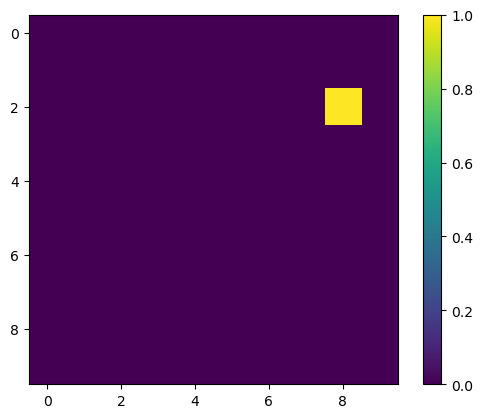

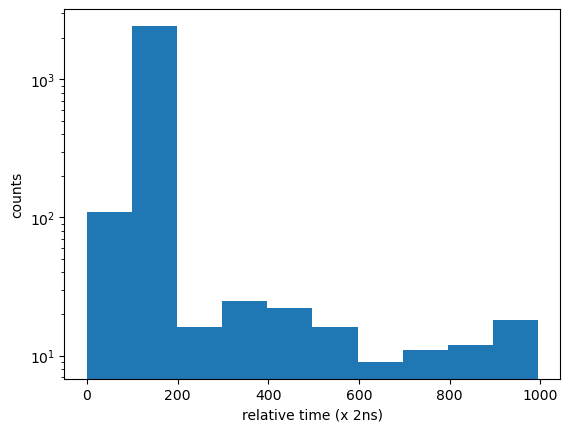

[168, 168, 113, 5, 112, 112, 165, 530, 163, 116, 169, 986, 169, 165, 111, 7, 164, 165, 115, 112, 116, 116, 0, 114, 109, 47, 163, 112, 114, 111, 170, 167, 112, 113, 169, 167, 111, 115, 170, 114, 111, 117, 114, 916, 116, 111, 116, 112, 911, 114, 166, 113, 112, 117, 165, 115, 309, 115, 169, 114, 115, 166, 111, 164, 164, 109, 113, 165, 110, 117, 118, 135, 109, 113, 115, 114, 111, 165, 115, 112, 112, 166, 116, 165, 117, 167, 114, 164, 166, 113, 159, 113, 167, 114, 108, 162, 117, 164, 166, 169, 108, 110, 163, 233, 116, 167, 112, 109, 739, 110, 168, 171, 170, 116, 113, 169, 111, 166, 162, 113, 113, 175, 112, 763, 115, 168, 167, 110, 117, 383, 114, 162, 110, 162, 110, 115, 164, 114, 850, 110, 113, 162, 165, 164, 111, 165, 110, 10, 114, 116, 115, 162, 362, 162, 114, 165, 111, 115, 166, 166, 116, 112, 165, 164, 113, 111, 168, 164, 114, 168, 108, 109, 111, 458, 165, 116, 164, 110, 165, 426, 167, 111, 110, 115, 113, 110, 165, 112, 113, 114, 890, 163, 168, 166, 160, 115, 111, 115, 112, 166, 113, 45

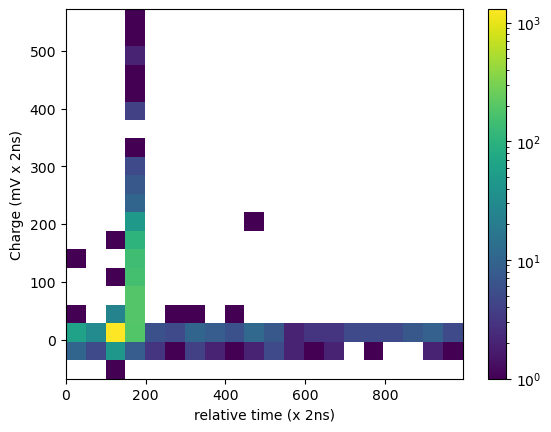

In [10]:
testA = np.zeros( (10, 10) )
testA[2][8] = 1
plt.imshow(testA)
plt.colorbar()
plt.show()

plt.hist(time_loc)
plt.ylabel("counts")
plt.xlabel("relative time (x 2ns)")
plt.yscale('log')
plt.show()

time_loc2=[]
chg_wtimee=[]
from matplotlib.colors import LogNorm
for i in range(len(chg_wtime)):
    if chg_wtime[i] < 600:
        time_loc2.append(time_loc[i])
        chg_wtimee.append(chg_wtime[i])
print(time_loc2)
print(chg_wtimee)
plt.hist2d(time_loc2, chg_wtimee, bins = 100, norm=LogNorm())
plt.ylabel("Charge (mV x 2ns)")
plt.xlabel("relative time (x 2ns)")
plt.colorbar()
plt.show()

[[3.400e+01 7.000e+00 3.200e+01 1.000e+01 3.200e+01 1.600e+01 8.000e+00
  3.800e+01 0.000e+00 4.400e+01]
 [2.860e+02 1.600e+01 2.940e+02 3.800e+01 3.680e+02 7.600e+01 3.800e+01
  3.530e+02 0.000e+00 8.000e+00]
 [9.500e+01 1.100e+01 9.500e+01 2.600e+01 1.040e+02 3.700e+01 2.500e+01
  9.400e+01 0.000e+00 1.000e+00]
 [7.200e+01 1.000e+01 7.300e+01 1.800e+01 7.600e+01 2.500e+01 2.200e+01
  6.700e+01 0.000e+00 0.000e+00]
 [1.276e+03 6.500e+01 1.279e+03 1.060e+02 1.532e+03 2.680e+02 1.160e+02
  1.459e+03 0.000e+00 0.000e+00]
 [1.990e+02 2.000e+01 2.180e+02 3.000e+01 2.640e+02 6.300e+01 4.400e+01
  2.420e+02 0.000e+00 0.000e+00]
 [4.400e+01 4.000e+00 3.700e+01 1.200e+01 5.300e+01 2.000e+01 1.600e+01
  5.300e+01 0.000e+00 0.000e+00]
 [1.900e+01 6.000e+00 1.800e+01 8.000e+00 1.900e+01 6.000e+00 3.000e+00
  1.900e+01 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [3.650e+02 3.290e+02 2.370e+02 1.080e+02 1.700e+01 1.0

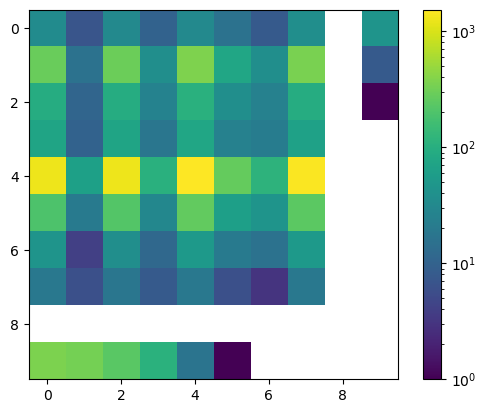

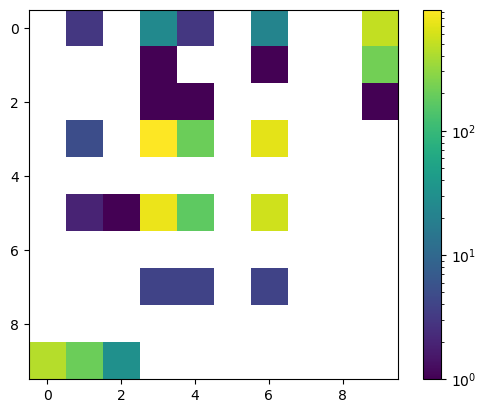

In [11]:
print(top_fire)
print(bot_fire)
print(np.shape(top_fire))

plt.imshow(top_fire, norm=colors.LogNorm())
plt.colorbar()
plt.show()

plt.imshow(bot_fire, norm=colors.LogNorm())
plt.colorbar()
plt.show()

In [ ]:
#print (schn)
#plt.figure()
f,a = plt.subplots(2,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(h_hodo[idx+0], bins=10, range=[0,10], label = "hodo. mod. {}".format(idx+1),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("Number of bars")
    ax.legend()   
plt.tight_layout()

f,a = plt.subplots(4,4)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(schn[idx+0], bins=50, range=[0,20], label = "chn {}".format(idx+1),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b1.png')

f,a = plt.subplots(4,4)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(schn[idx+16], bins=50, range=[0,20], label = "chn {}".format(idx+16),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b2.png')

f,a = plt.subplots(4,4)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(schn[idx+32], bins=50, range=[0,20], label = "chn {}".format(idx+32),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b3.png')

f,a = plt.subplots(4,4)
a = a.ravel()
for idx,ax in enumerate(a):
    if idx +48 == 61 or idx + 48 == 62:
        ax.hist(schn[idx+48], bins=50, range=[0,1000], label = "chn {}".format(idx+48),\
                    histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    else:
        ax.hist(schn[idx+48], bins=50, range=[0,20], label = "chn {}".format(idx+48),\
                    histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b4.png')

f,a = plt.subplots(4,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(schn[idx+64], bins=50, range=[0,4], label = "chn {}".format(idx+1),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b5_1.png')

f,a = plt.subplots(4,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(schn[idx+72], bins=50, range=[0,4], label = "chn {}".format(idx+9),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b5_2.png')

f,a = plt.subplots(4,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(schn[idx+80], bins=50, range=[0,4], label = "chn {}".format(idx+17),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b5_3.png')

f,a = plt.subplots(4,2)
a = a.ravel()
for idx,ax in enumerate(a):
    if idx + 25 == 33:
        break
    ax.hist(schn[idx+88], bins=50, range=[0,4], label = "chn {}".format(idx+25),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b5_4.png')

In [ ]:
# summed waveform of bottom PMTs
user_list=['adc_b1_ch1', 'adc_b1_ch2', 'adc_b1_ch3', 'adc_b1_ch4',
            'adc_b1_ch5', 'adc_b1_ch6', 'adc_b1_ch7', 'adc_b1_ch8',
            'adc_b1_ch9', 'adc_b1_ch10', 'adc_b1_ch11','adc_b1_ch12',
             'adc_b1_ch13', 'adc_b1_ch14', 'adc_b1_ch15','adc_b2_ch0',
             'adc_b2_ch1', 'adc_b2_ch2', 'adc_b2_ch3','adc_b2_ch4',
             'adc_b2_ch5', 'adc_b2_ch6', 'adc_b2_ch7','adc_b2_ch8',
             'adc_b2_ch9', 'adc_b2_ch10', 'adc_b2_ch11','adc_b2_ch12',
             'adc_b2_ch13', 'adc_b2_ch14', 
            ]
dp.set_user_summed_channel_list(user_list)
dp.display_waveform(314, 'sum')

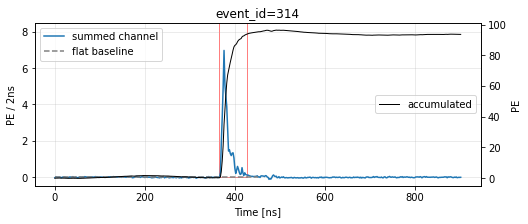

In [8]:
# summed waveform of side PMTs
user_list=[300, 301, 302, 303, 304, 305, 306, 307, 
           308, 309, 310, 311, 312, 313, 314, 315]
dp.set_user_summed_channel_list(user_list)
dp.display_waveform(314, 'sum')


## Aggregated Analysis 

In [9]:
def correct_trg_delay(adc):
    """
    3 digitizer boards are in daisy chain setup. The delay between TRG_IN and TRG_OUT is 48 ns. 
    To alogn muon pulse, we need to shift the waveform from different boards.
    
    Args:
        adc: dict
    """
    adc_corr = adc.copy()
    dT_ns = 48 # externally calibrated
    dS = dT_ns//2
    for ch, val in adc.items():
        a = np.stack(val)
        if "_b1" in ch:
            a=a[:, dS*2:]
        elif "_b2" in ch:
            a=a[:, dS:-dS]
        elif "_b3" in ch:
            a=a[:, 0:-dS*2]
        else:
            print("ERROR")
            return None
        adc_corr[ch] = a
    return adc_corr

In [10]:
'''
All 48 digitizer channels are active. Only 46 of them are used to digitize PMT signal. Two are used to digitize bottom paddles. 

We did not have SPE calibration of paddles. So we need to exclude the two paddle channels when doing the SPE normalization.
'''
BP_CH_LIST = ['adc_b1_ch0', 'adc_b2_ch15']

In [11]:

def load_data(fpath):
    """
    This function load the root file, and return the data as a dictionary.
    
    Since it loads the entire data set at once, it may take a few minutes.
    
    Args:
        fpath: str. Path to root file
    """
    f = uproot.open(fpath)
    t = f['daq']
    event_id =  t['event_id'].array(library='np')
    event_ttt =  t['event_ttt'].array(library='np')
    n_events=len(event_id)
    
    ch_names = []
    ch_id = []
    for k in t.keys():
        if k[0:4]=='adc_':
            ch_names.append(k)
            tmp = re.findall(r'\d+', k)
            ch_id.append( int(tmp[0])*100+int(tmp[1]) )
    adc =  t.arrays(ch_names, library='np')
    map_ch_name= dict(zip(ch_id, ch_names)) # from ch_id to ch_name
    
    n_samples = len(adc['adc_b1_ch1'][0])
    
    # do a simple flat baseline subtraction
    amp_mV = {}
    amp_pe = {} # unit: pe/ns
    for ch in ch_names:
        amp_mV[ch] = np.zeros([n_events, n_samples])
        for i in range(n_events):
            amp_mV[ch][i] = (np.median(adc[ch][i])-adc[ch][i])*ADC_TO_MV
        if ch in BP_CH_LIST:
            continue
        amp_pe[ch] = np.zeros([n_events, n_samples])
        for i in range(n_events):
            amp_pe[ch][i] = amp_mV[ch][i]/SAMPLE_TO_NS/50/1.6
    
    amp_mV = correct_trg_delay(amp_mV)
    amp_pe = correct_trg_delay(amp_pe)
    
    return dict(
        n_events=n_events,
        n_samples=n_samples,
        event_id=event_id,
        event_ttt=event_ttt,
        ch_names = ch_names,
        ch_id = ch_id,
        amp_mV = amp_mV,
        amp_pe = amp_pe,
    )

data = load_data(fpath)

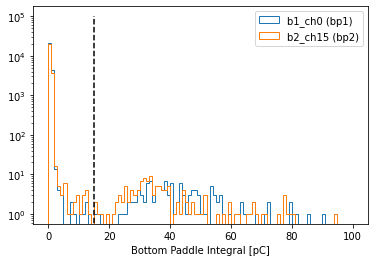

In [12]:
"""
Let's take a look at the area of the two paddles. The area is just integral 
over the entire waveform. Then we convert its unit to charge [pC] (50 Ohm input 
resistance assumed)

Note:
    Since data is a dictionary, you can access its variable via key word. 
Since amp_mV variable is another dictionary, you can access channel via key word
"""
amp_bp1 = data['amp_mV']['adc_b1_ch0'] # bottom paddle 1 baseline subtracted waveform
amp_bp2 = data['amp_mV']['adc_b2_ch15'] # bottom paddle 2 baseline subtracted waveform
area_bp1 = np.sum(amp_bp1, axis=1)*2/50 # unit: pC
area_bp2 = np.sum(amp_bp2, axis=1)*2/50 # unit: pC
plt.figure()
plt.hist(area_bp1, bins=100, range=(0, 100), histtype='step', label='b1_ch0 (bp1)');
plt.hist(area_bp2, bins=100, range=(0, 100), histtype='step', label='b2_ch15 (bp2)');
plt.xlabel('Bottom Paddle Integral [pC]')
plt.legend()
plt.yscale('log')
plt.vlines(15, 0, 1e5, linestyle='--', color='k')
plt.show()

In [15]:
"""
Make a selection of muon passing through bottom paddles
"""
cut_pC=15 # 15pC
print('num of muons through bp1:', len(area_bp1[area_bp1>cut_pC]))
print('num of muons through bp2:', len(area_bp2[area_bp2>cut_pC]))

mask = np.logical_or(area_bp1>cut_pC,  area_bp2>cut_pC)
event_id_selected = data['event_id'][mask]
print("the following muon pass through bot pad:\n", event_id_selected)

num of muons through bp1: 132
num of muons through bp2: 136
the following muon pass through bot pad:
 [  209   406   664   767   848  1024  1243  1299  1376  1410  1444  1465
  1782  2475  2604  2726  2755  2863  2951  3428  3480  3583  3626  3925
  4119  4129  4233  4495  4824  4895  4943  4991  5000  5186  5370  5578
  5673  5788  5828  6335  6498  6566  6640  6964  7046  7284  7411  7658
  7714  7810  8578  8808  8905  8983  9063  9293  9462  9711  9793  9799
  9825  9894  9928 10254 10398 10491 10586 10797 10984 11033 11080 11257
 11334 11450 11746 12533 13131 13205 13347 14503 14637 14856 14945 14018
 14196 15256 15498 15571 16614 16618 16942 16302 17093 17146 17157 17680
 17922 18440 18513 18665 18682 18723 18210 18399 19047 19286 19475 19942
 20616 20958 20043 20340 20444 21204 21369 21423 21600 21724 21867 21999
 22950 23037 23139 23310 23452 23531 23546 23589 23921 24692 24248 24339
 24429 25501 26627 26007 26379 26441 27048 27184 27498 27727 27999 28779
 28930 28965 28194 282

In [16]:
BT_PMT_LIST=['adc_b1_ch1', 'adc_b1_ch2', 'adc_b1_ch3', 'adc_b1_ch4',
            'adc_b1_ch5', 'adc_b1_ch6', 'adc_b1_ch7', 'adc_b1_ch8',
            'adc_b1_ch9', 'adc_b1_ch10', 'adc_b1_ch11','adc_b1_ch12',
             'adc_b1_ch13', 'adc_b1_ch14', 'adc_b1_ch15','adc_b2_ch0',
             'adc_b2_ch1', 'adc_b2_ch2', 'adc_b2_ch3','adc_b2_ch4',
             'adc_b2_ch5', 'adc_b2_ch6', 'adc_b2_ch7','adc_b2_ch8',
             'adc_b2_ch9', 'adc_b2_ch10', 'adc_b2_ch11','adc_b2_ch12',
             'adc_b2_ch13', 'adc_b2_ch14', 
            ]


def calc_rq_vars(data, BP_CH_LIST=['adc_b1_ch0', 'adc_b2_ch15'], n_events=10000):
    """
    RQ stands for reduced quality. High level variables extracted from waveform.

    Args:
        data: dict. Same data returned by load_data function above.
        BP_CH_LIST: list, bottom paddle channels
        n_events: int, number of events to process

    return: 
        dict
    """
    max_n_events = data['n_events']
    n_samples = data['n_samples']
    if n_events<=0 or n_events>max_n_events:
        n_events=max_n_events
        
    pT_ns=np.zeros(n_events) # peak time
    peak_pe=np.zeros(n_events)
    npe=np.zeros(n_events) # num of pe
    npe_bt=np.zeros(n_events) # num of pe for bt
    npe_side=np.zeros(n_events)
    sba = np.zeros(n_events)
    bp1_area_pC = np.zeros(n_events)
    bp2_area_pC = np.zeros(n_events)
    for i in range(n_events):
        if i % (n_events//10) ==0:
            print("processing ", i)
        amp_sum_pe =0
        amp_bt_pe = 0
        amp_side_pe = 0
        for ch in data['ch_names']:
            if ch in BP_CH_LIST:
                continue
            amp_sum_pe += data['amp_pe'][ch][i]
            if ch in BT_PMT_LIST:
                amp_bt_pe += data['amp_pe'][ch][i]
            else:
                amp_side_pe+= data['amp_pe'][ch][i]
        idx = np.argmax(amp_sum_pe)
        pT_ns[i] = idx*2
        npe[i] = np.sum(amp_sum_pe[160:250])*2
        npe_bt[i] = np.sum(amp_bt_pe[160:250])*2
        npe_side[i] = np.sum(amp_side_pe[160:250])*2
        if (npe_side[i]+npe_bt[i])==0:
            sba[i]=None
        else:
            sba[i] = (npe_side[i]-npe_bt[i])/(npe_side[i]+npe_bt[i])
        peak_pe[i] = np.max(amp_sum_pe[160:250])
        
        bp1_area_pC[i] = np.sum(data['amp_mV']['adc_b1_ch0'][i])*2/50
        bp2_area_pC[i] = np.sum(data['amp_mV']['adc_b2_ch15'][i])*2/50

    return dict(
        npe=npe, # number of total PE by all channels
        npe_bt=npe_bt, # num. of PE from bottom PMTs
        npe_side=npe_side, # num. of PE from side PMTs
        pT_ns=pT_ns, # peak time of summed waveform in ns
        peak_pe=peak_pe,# peak height of summed waveform in pe/2ns
        sba=sba, # side-bottom asymmetry: (npe_side-npe_bt)/npe
        bp1_area_pC=bp1_area_pC, # bot paddle 1 area, unit pC
        bp2_area_pC=bp2_area_pC # bot paddle 2 area, unit pC
    )

rq = calc_rq_vars(data, n_events=100000)

processing  0
processing  5139
processing  10278
processing  15417
processing  20556
processing  25695
processing  30834
processing  35973
processing  41112
processing  46251
processing  51390


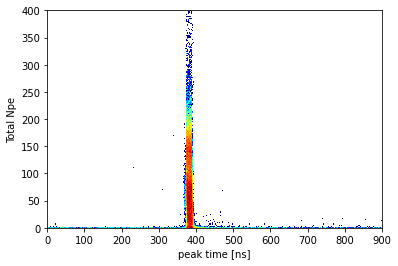

In [17]:
"""
Once you have RQ, making more plots ...
"""

plt.figure()
plt.hist2d(rq['pT_ns'], rq['npe'], bins=[450, 200], range=((0, 900), (0, 400)), 
                                                   norm=colors.LogNorm(), cmap='jet');
plt.xlabel('peak time [ns]')
plt.ylabel('Total Npe')
plt.show()

In [19]:
"""
mask just means selection; it's an array of bool, can be used to select a variable

Create several mask

- muon_mask = events whose peak time fall within the expected muon region. See the 2D plot above.
- bp_mask = events which produce signals in bottom paddles (see bottom paddle integral plot)
"""
muon_mask = (rq['pT_ns']>=360) & (rq['pT_ns']<400)

bp_mask = np.logical_or(rq['bp1_area_pC']>15, rq['bp2_area_pC']>15) # we actually defined this mask before. 

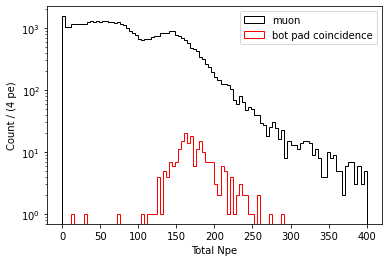

In [20]:
plt.figure()
plt.hist(rq['npe'][muon_mask], bins=100, range=(0, 400), histtype='step', color='black', label='muon');
plt.hist(rq['npe'][bp_mask], bins=100, range=(0, 400), histtype='step', color='red', label='bot pad coincidence');

plt.xlabel('Total Npe')
plt.ylabel('Count / (4 pe)')
plt.yscale('log')
plt.legend()
plt.show()

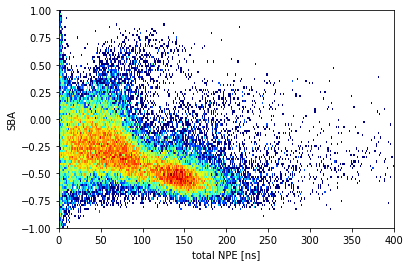

In [21]:
plt.figure()
plt.hist2d(rq['npe'][muon_mask],rq['sba'][muon_mask],  
           bins=[300, 100], range=((0, 400), (-1, 1)), 
            norm=colors.LogNorm(), cmap='jet');
plt.xlabel('total NPE [ns]')
plt.ylabel('SBA')
plt.show()

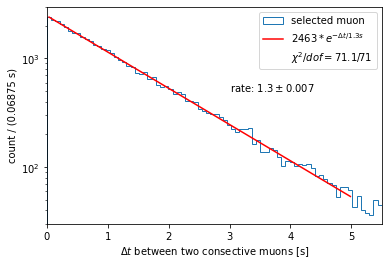

In [22]:
"""
Get event time stamp, select muons, and compute time difference 
between two consective muon
"""
muon_t = data['event_ttt'][muon_mask]*8e-9
dt = muon_t[1:]-muon_t[:-1]


plt.figure()
h = plt.hist(dt, bins=80, range=(0, 5.5), histtype='step', label='selected muon');
plt.yscale('log')
plt.xlabel(r'$\Delta t$ between two consective muons [s]')
plt.ylabel('count / (0.06875 s)')


"""
Do an exponential fit
"""
from scipy.optimize import curve_fit

def expo(x, tau, A):
    return A*np.exp(-x/tau)

def calc_chi2(func, xdata, ydata, popt):
    y = func(xdata, popt[0], popt[1])
    r = (y-ydata)/np.sqrt(ydata)
    r2 = np.square(r)
    return np.sum(r2)

ydata = h[0]
xdata = (h[1][1:]+h[1][:-1])/2
fit_mask = (xdata>0.0) & (xdata<5)
sigma = np.sqrt(ydata[fit_mask])
popt, pcov = curve_fit(expo, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=(1.2, data['n_events']))
x = np.linspace(xdata[fit_mask][0], xdata[fit_mask][-1], 100)    
y = expo(x, popt[0], popt[1])

chi2 = calc_chi2(expo, xdata[fit_mask], ydata[fit_mask], popt)
dof = len(xdata[fit_mask])-2
plt.plot(x, y, color='red', label='$%d*e^{-\Delta t / %.1f s}$' % (popt[1], popt[0]))
plt.xlim([0, 5.5])
plt.ylim([30, 3e3])

plt.plot([0,0], [0, 0], color='white', label='$\chi^2/dof=%.1f/%d$'%(chi2, dof))
err = np.diag(pcov)
err = np.sqrt(err)
plt.text(3, 500, r'rate: $%.1f \pm %.3f$' % (popt[0], err[0]))
plt.legend()

plt.show()

# Below are extra stuff not fully tested yet

In [ ]:
def get_freq_spectrum(a):
    sample_rate=500e6 # 500MHz
    n_samples = len(a)
    duration = n_samples/sample_rate
    a=a-np.mean(a)
    yf = rfft(a)
    xf = rfftfreq(n_samples, 1 / sample_rate)
    return xf, yf
    

def get_avg_freq_per_time_slice(adc_b2_ch1, event_id):
    
    trg_rate= 1
    sample_rate=500e6 # 500MHz
    
    dt = (event_id-event_id.min())/trg_rate
    
    n_avg = 50000
    yf_avg = []
    xf_avg = []
    dt_h = []
    n_events = len(event_id)
#     n_events=10000
    for i in range(len(event_id)):
        xf, yf = get_freq_spectrum(adc_b2_ch1[i])
        if i % n_avg == 0:
            if i == 0:
                y_avg = yf
            else:
                yf = yf/n_avg
                yf_avg.append(y_avg)
                xf_avg.append(xf)
                dt_h.append(dt[i])
                y_avg = yf
        else:
            y_avg += yf
            
    dt_l = np.array(dt_h) - (dt[n_avg]-dt[0])
    return dt_l, np.array(xf_avg), np.array(yf_avg)

def get_avg_freq_per_run(data, chName='adc_b1_ch14', n_events=1000):
    
    if n_events<=0 or n_events>data['n_events']:
        n_events=data['n_events']
    
    amp = data['amp_mV'][chName]
    yf_avg = []
    xf_avg = []
    for i in range(n_events):
        xf, yf = get_freq_spectrum(amp[i])
        if i == 0:
            y_avg = yf
        else:
            y_avg += yf
    y_avg = y_avg/n_events
    yf_avg.append(y_avg)
    xf_avg.append(xf)
    return np.array(xf_avg), np.array(yf_avg)

In [ ]:
xf, yf = get_avg_freq_per_run(data, chName="adc_b1_ch14", n_events=100)

In [ ]:


plt.plot(xf[1:], np.abs(yf[1:]))
plt.yscale('log')
plt.xlim([1/(500*2*1e-9), 3e8])
# plt.ylim([0, 6.5e6])

plt.xlabel('Freq [Hz]')
plt.ylabel('ADC (abs)')
plt.title('LED Off Run (June 15 2022); b3p1', fontsize=14);
plt.show()